In [ ]:
import sys,os
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import contractions
from symspellpy.symspellpy import SymSpell
import pkg_resources
import re
import swifter
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word.context_word_embs as aug
from tqdm.auto import tqdm
from gensim.models import Word2Vec
import pickle

In [ ]:
train_data = pd.read_csv('train.csv').drop(columns = 'id')
train_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
class data_visualization_exploration:

    '''
    Use this class for both visualization and exploration of tweets
    Methods :-

    1. count_words
    2. most_common
    3. show_wordcloud
    4. visualize_mostcommon


    '''

    def __init__(self, data):

        self.data = data
        self.tweets = data['tweet']
        self.reviews = data['label']
        self.word_counter = None
        self.all_words = None
        self.review_type = None
        
    def count_words(self,review_type = 'all'):
        if review_type == 'all':
            all_words = [word for tweet in self.tweets for word in nltk.word_tokenize(tweet)]
        elif review_type == 0:
            all_words = [word for i,tweet in enumerate(self.tweets) for word in nltk.word_tokenize(tweet) if 
                        self.reviews[i] == 0]
        else:
            all_words = [word for i,tweet in enumerate(self.tweets) for word in nltk.word_tokenize(tweet) if 
                        self.reviews[i] == 1]
            
        self.all_words = all_words
        word_counter = nltk.FreqDist(all_words)
        self.word_counter = word_counter

    def most_common(self, n=10):

        return self.word_counter.most_common(n)

    def show_wordcloud(self, review_type):
        '''
        positive: 0
        negative: 1

        '''
        review_dict = {0:'positive',1:'negative'}
        allowed_cateogory = list(self.reviews.unique())
        if review_type not in allowed_cateogory:
            raise ValueError("Invalid argument expected {} got {}".format(
                allowed_cateogory, review_type))

        else:
            required_data = self.data.loc[self.reviews == review_type]
            wordcloud = WordCloud(background_color='white',
                                  width=1600, height=800).generate(' '.join(required_data['tweet'].tolist()))

            plt.figure(figsize=[20, 10],facecolor ='k')
            plt.title(review_dict[review_type].upper(),color = 'white',fontsize = 15)
            plt.imshow(wordcloud)


    def visualize_mostcommon(self,n_words = 20,review_type = 'all'):
        
        review_dict = {0:'Positive',1:'Negative','all':'all'}
        data_visualization_exploration_obj = data_visualization_exploration(self.data.copy())
        data_visualization_exploration_obj.count_words(review_type=review_type)
        
        most_common = dict(data_visualization_exploration_obj.most_common(n = n_words))
        token = list(most_common.keys())
        count = list(most_common.values())

        plt.figure(figsize=[20,10])
        sns.barplot(x = token, y = count)
        plt.xticks(fontsize = 15)
        plt.xlabel('Top {} words in {} reviews'.format(n_words,review_dict[review_type]),fontsize = 15)
        plt.ylabel('Count',fontsize = 15)
        plt.show()
        
    def proportion_of_reviews(self):
        
        plt.figure(figsize = [15,15])
        sns.countplot(self.reviews)
        plt.xticks([0,1],['positive','negative'],fontsize = 15)
        plt.xlabel('Type of Reviews',fontsize = 15)
        plt.ylabel('Count',fontsize = 15)
        plt.show()
        

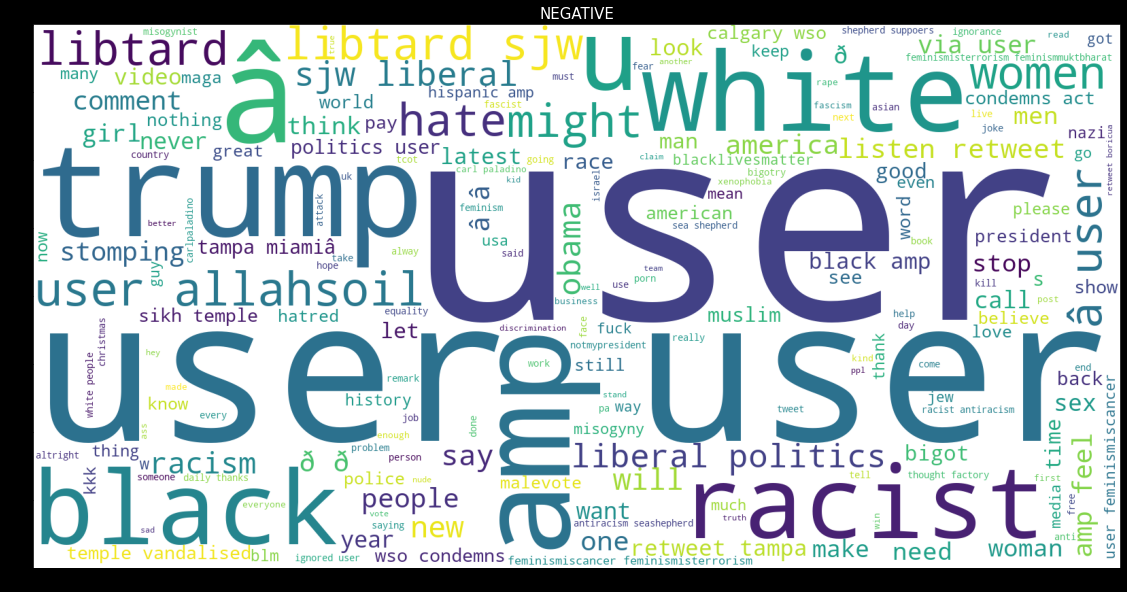

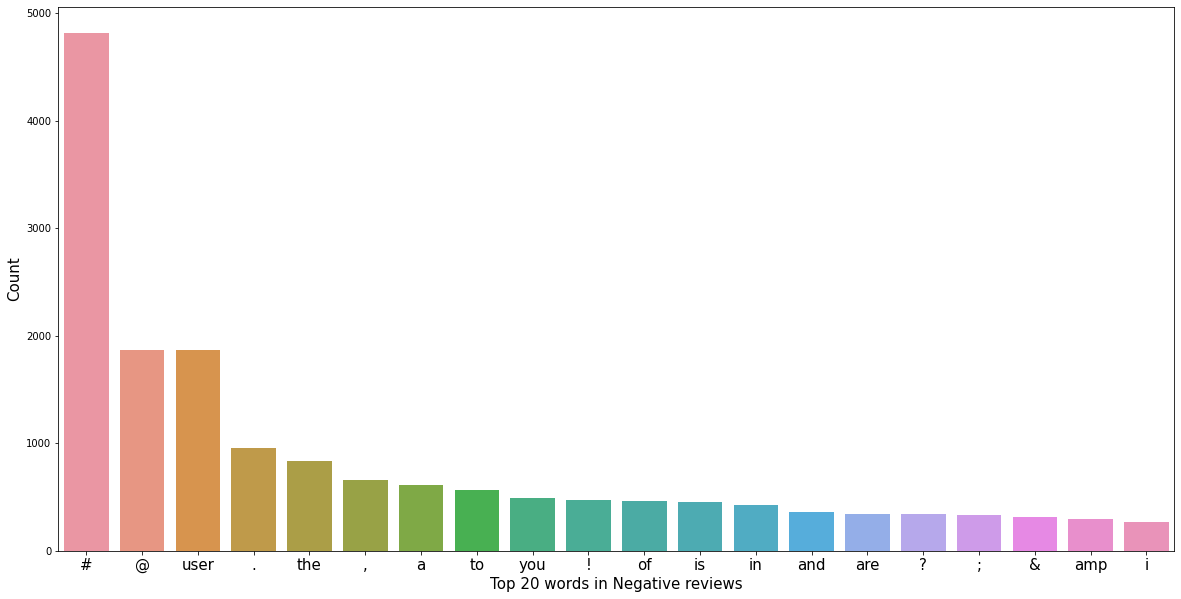

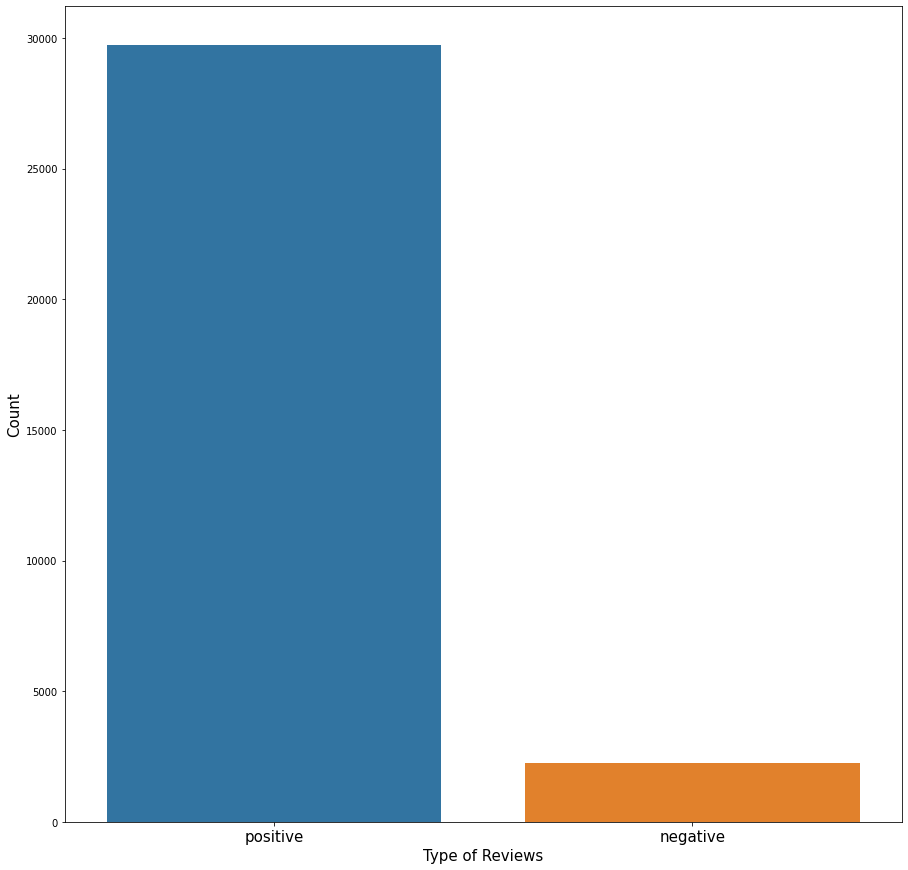

In [ ]:
# Before preprocessing visualization
# Negative reviews
vis_exp_object = data_visualization_exploration(train_data.copy())
vis_exp_object.count_words(review_type=1)
most_common_negative = vis_exp_object.most_common(n = 20)
vis_exp_object.show_wordcloud(1)
vis_exp_object.visualize_mostcommon(review_type=1)
vis_exp_object.proportion_of_reviews()

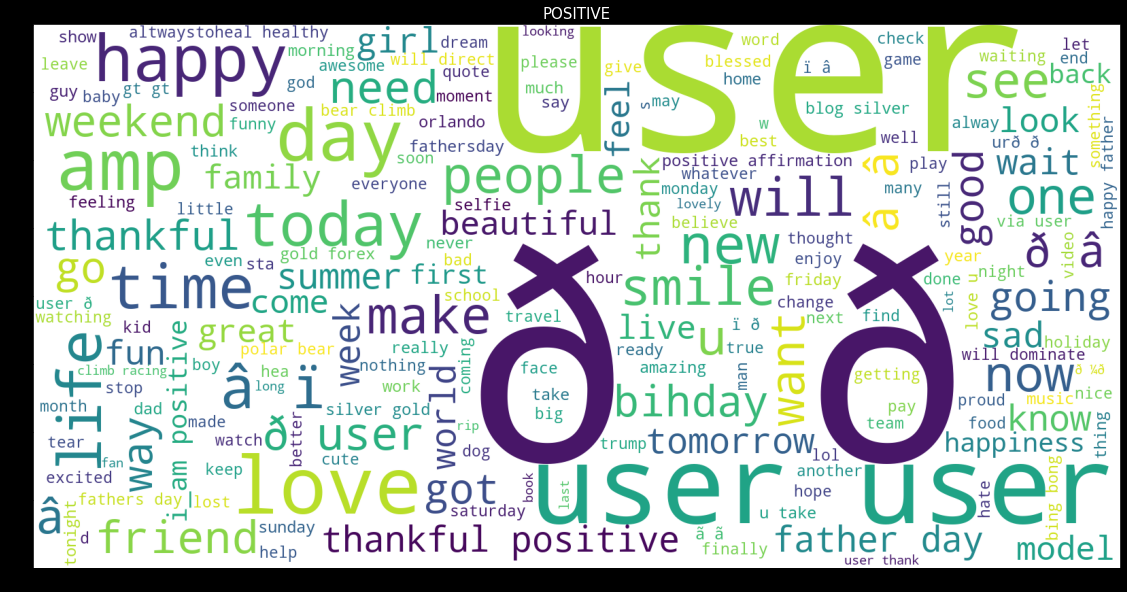

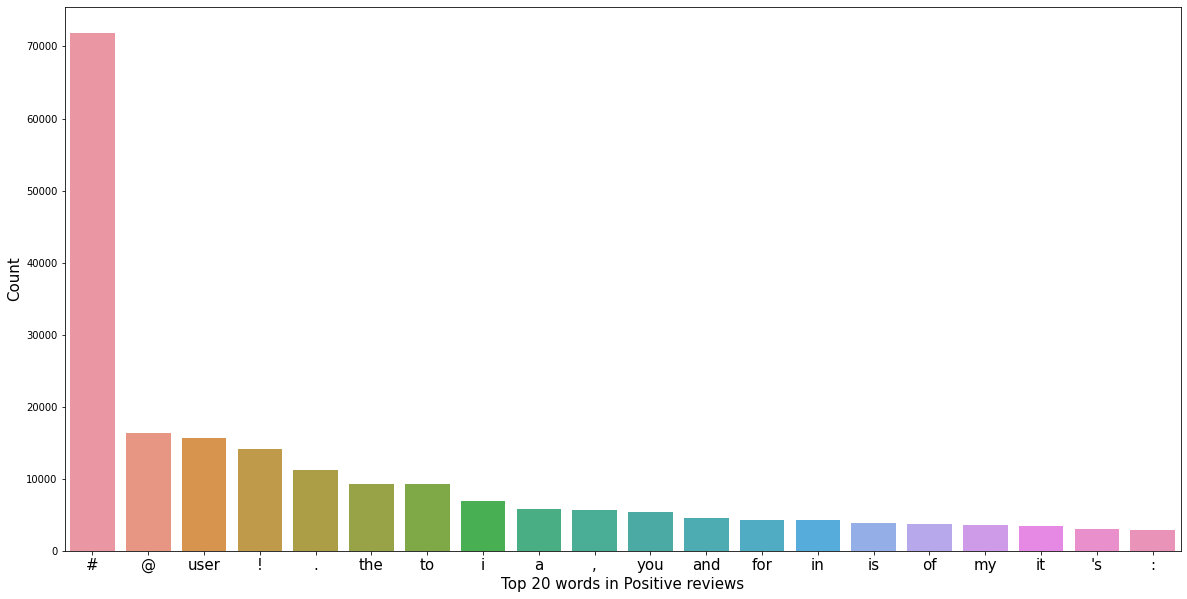

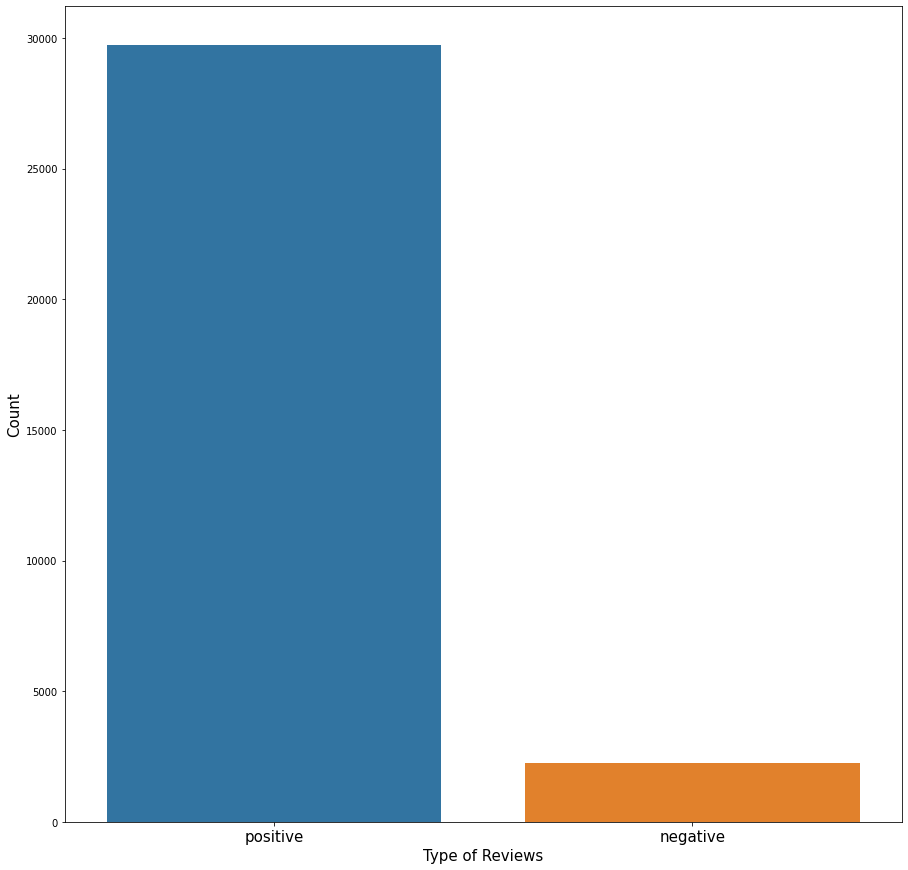

In [ ]:
# Before preprocessing visualization
# Positive reviews
vis_exp_object = data_visualization_exploration(train_data.copy())
vis_exp_object.count_words(review_type=0)
most_common_positive = vis_exp_object.most_common(n = 20)
vis_exp_object.show_wordcloud(0)
vis_exp_object.visualize_mostcommon(review_type=0)
vis_exp_object.proportion_of_reviews()

In [ ]:
class data_cleaning:

    '''
    Methods available:

    1. remove_punctuation
    2. lower_case
    3. remove_user :- removes '@user'
    4. remove_stopwords
    5. remove_null_rows
    6. expand_contractions
    7. lemmatize_text
    8. word_segmentation
    9. return_data
    '''

    def __init__(self,tweets):

        self.tweets = tweets

    def return_data(self):

        return self.tweets

    def remove_punctuation(self):
        
        print("Removing Punctuations")
        self.tweets = self.tweets.swifter.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))    
        print("Punctuations Removed")
        print("----------------------------------------------------------------------------------------")
    def lower_case(self):
        
        print("Converting to lower case")
        self.tweets = self.tweets.swifter.apply(lambda x: x.lower())
        print("Converted to lower case")
        print("----------------------------------------------------------------------------------------")
    def remove_user(self):
        
        print("Removing \"@user\"")
        self.tweets = self.tweets.swifter.apply(lambda x: str(x).replace('@user',''))
        print("Removed \"@user\"")
        print("----------------------------------------------------------------------------------------")

    def remove_stopwords(self):
        
        print("Removing Stopwords")
        self.tweets = self.tweets.swifter.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) 
                                                            if word not in set(stopwords.words('english'))]))
        print("Stopwords Removed")
        print("----------------------------------------------------------------------------------------")
    def remove_null_rows(self):
        
        print("Removing Null Rows")
        self.tweets = self.tweets[self.tweets.notnull()]
        print("Null Rows Removed")
        print("----------------------------------------------------------------------------------------")
        
    def expand_contractions(self):
        
        print("Expanding Contractions")
        # We didn't use word_tokenize as that will treat "\'" as a word ie; punctuations
        self.tweets = self.tweets.swifter.apply(lambda x: contractions.fix(x))
        print("Contractions Expanded")
        print("----------------------------------------------------------------------------------------")
    def lemmatize_text(self):
        
        print("Lemmatizing text")
        lemmatizer = nltk.stem.WordNetLemmatizer()
        self.tweets = self.tweets.swifter.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))
        print("Text Lemmatized")
        print("----------------------------------------------------------------------------------------")
        
    def spell_correction(self):
        
        print("Correcting Spellings")
        max_dictionary_edit_distance = 2
        prefix_length = 7
        spellchecker = SymSpell(max_dictionary_edit_distance,prefix_length)
        
        dictionary_path = pkg_resources.resource_filename('symspellpy','frequency_dictionary_en_82_765.txt')
        bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
        spellchecker.load_dictionary(dictionary_path,term_index=0,count_index=1)
        spellchecker.load_bigram_dictionary(bigram_path,term_index=0,count_index=2)
        
        self.tweets = self.tweets.swifter.apply(lambda x: spellchecker.lookup_compound(x,max_edit_distance=max_dictionary_edit_distance)[0].term)

        print("Spellings Corrected ")
        print("----------------------------------------------------------------------------------------")
        
    def word_segmentation(self):
        
        print("Segmenting Sentences")
        max_dictionary_edit_distance = 0
        prefix_length = 7
        
        word_segmentator = SymSpell(max_dictionary_edit_distance,prefix_length)
        
        dictionary_path = pkg_resources.resource_filename('symspellpy','frequency_dictionary_en_82_765.txt')
        word_segmentator.load_dictionary(dictionary_path,term_index=0,count_index=1)
        
        self.tweets = self.tweets.swifter.apply(lambda x: word_segmentator.word_segmentation(x).corrected_string)
        print("Sentences Segmented")
        print("----------------------------------------------------------------------------------------")
        
    def __non_numeric(self,word):
        
        char_list = list(word)
        for char in char_list:
            if (char in '0123456789') or (char in '$,%\"'):
                return False
            
        return True
        
    
    
    

In [ ]:
class data_cleaning_pipeline:
    
    def __init__(self,tweets):
        
        self.tweets = tweets
        
    def apply_pipeline(self):
        
        data_cleaning_object = data_cleaning(self.tweets)
        data_cleaning_object.remove_null_rows()
        data_cleaning_object.remove_user()
        data_cleaning_object.expand_contractions()
        data_cleaning_object.word_segmentation()
        data_cleaning_object.spell_correction()
        data_cleaning_object.remove_punctuation()
        data_cleaning_object.lower_case()
        data_cleaning_object.remove_stopwords()
        data_cleaning_object.lemmatize_text()
        
        
        transformed_data = data_cleaning_object.tweets
        
        return transformed_data
    
       

In [ ]:
data_cleaning_pipeline_obj = data_cleaning_pipeline(train_data['tweet'].copy())
transformed_data = data_cleaning_pipeline_obj.apply_pipeline()
train_data['transformed_text'] = transformed_data
train_data.head()

Removing Null Rows
Null Rows Removed
----------------------------------------------------------------------------------------
Removing "@user"


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Removed "@user"
----------------------------------------------------------------------------------------
Expanding Contractions


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Contractions Expanded
----------------------------------------------------------------------------------------
Segmenting Sentences


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Sentences Segmented
----------------------------------------------------------------------------------------
Correcting Spellings


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Spellings Corrected 
----------------------------------------------------------------------------------------
Removing Punctuations


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Punctuations Removed
----------------------------------------------------------------------------------------
Converting to lower case


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Converted to lower case
----------------------------------------------------------------------------------------
Removing Stopwords


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Stopwords Removed
----------------------------------------------------------------------------------------
Lemmatizing text


Pandas Apply:   0%|          | 0/31962 [00:00<?, ?it/s]

Text Lemmatized
----------------------------------------------------------------------------------------


,label,tweet,transformed_text
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks left credit use offer wheelchair van pi...
2,0,bihday your majesty,big day majesty
3,0,#model i love u take with u all the time in ...,model love take time urn
4,0,factsguide: society now #motivation,fact guide society motivation


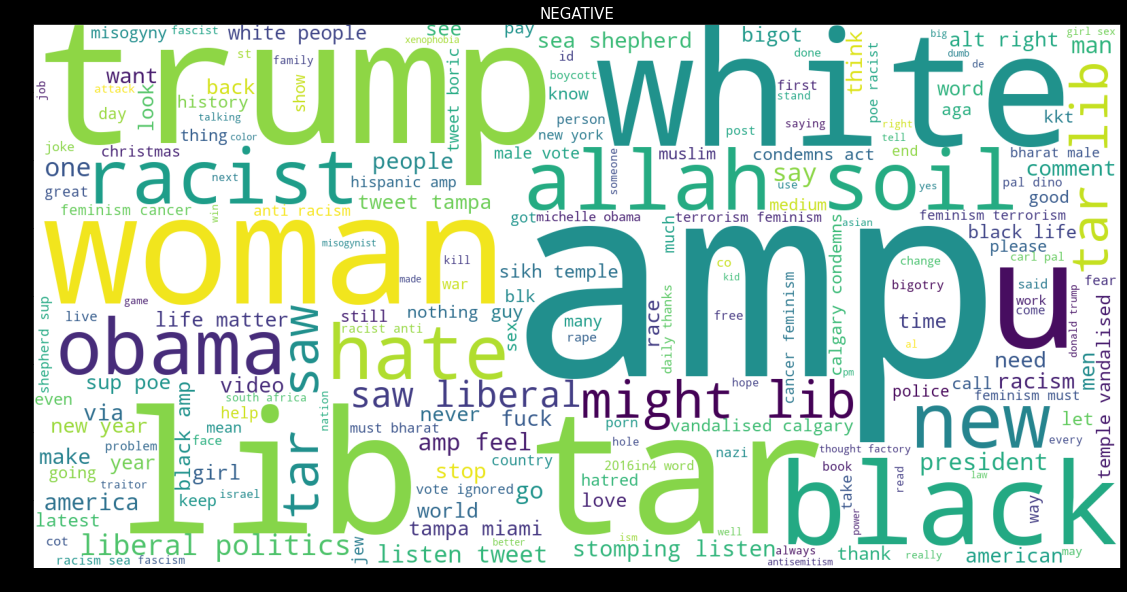

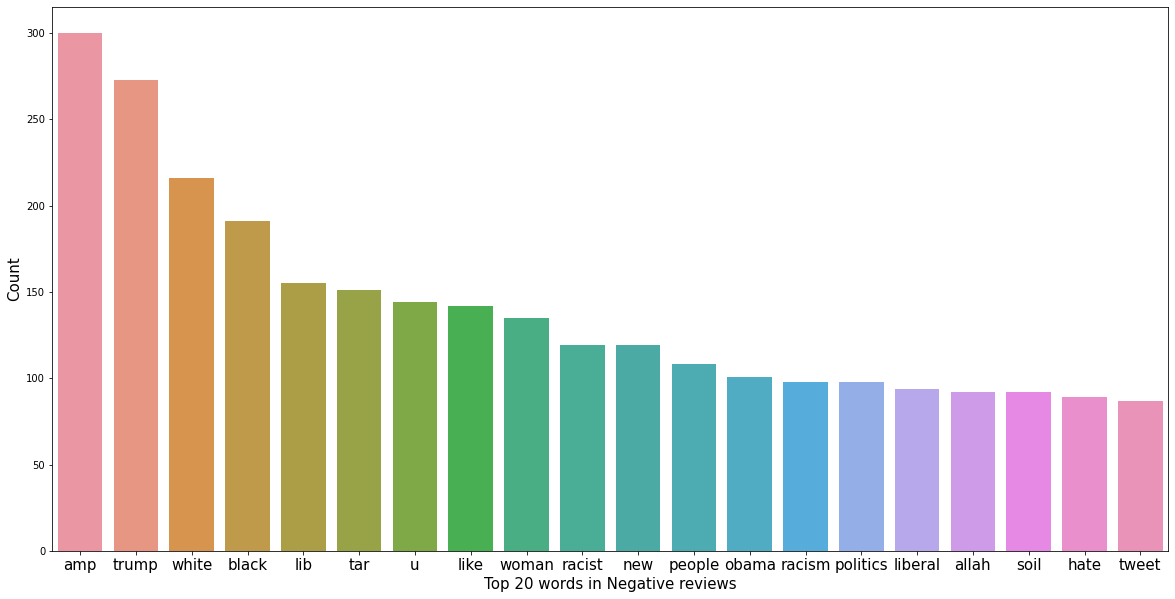

In [ ]:
# After preprocessing visualization
# Negative reviews
dummy_train_data = train_data.drop(columns='tweet')
dummy_train_data.rename(columns = {'transformed_text':'tweet'},inplace=True)
vis_exp_object_new = data_visualization_exploration(dummy_train_data)
vis_exp_object_new.count_words(review_type=1)
most_common_negative_new = vis_exp_object_new.most_common(n = 20)
vis_exp_object_new.show_wordcloud(1)
vis_exp_object_new.visualize_mostcommon(review_type=1)

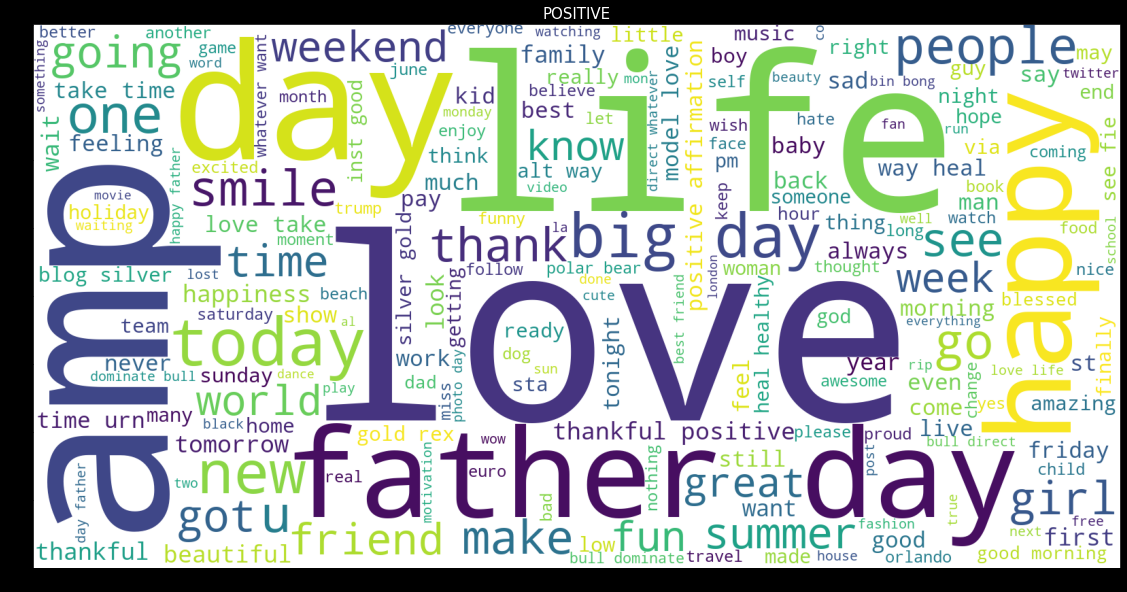

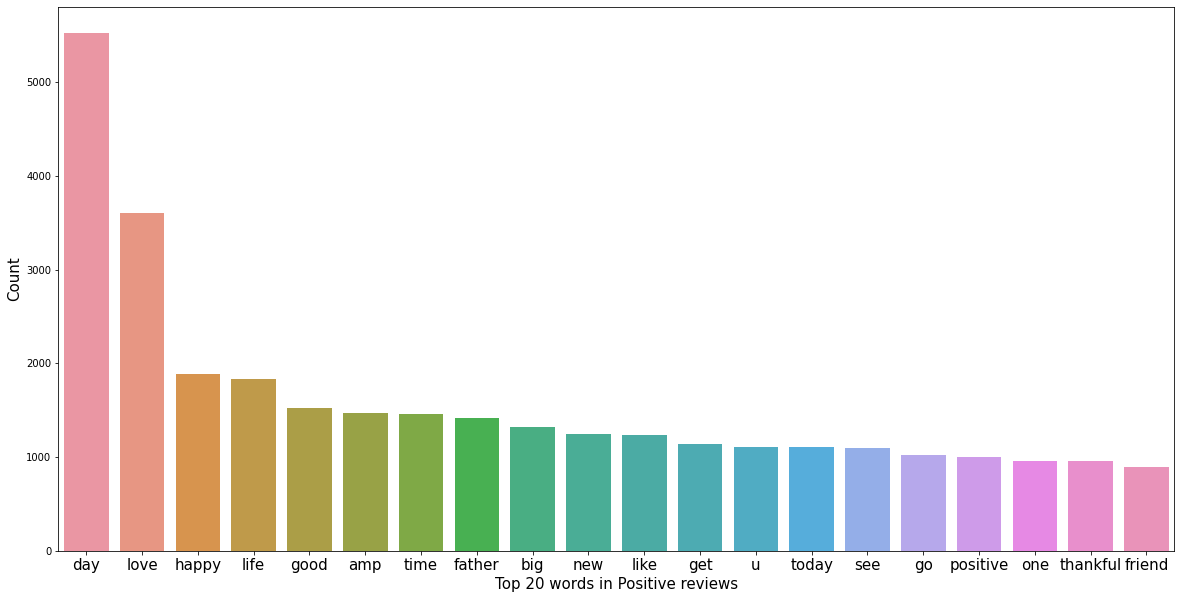

In [ ]:
# After preprocessing visualization
# Positive reviews
dummy_train_data = train_data.drop(columns='tweet')
dummy_train_data.rename(columns = {'transformed_text':'tweet'},inplace=True)
vis_exp_object_new = data_visualization_exploration(dummy_train_data)
vis_exp_object_new.count_words(review_type=0)
most_common_negative_new = vis_exp_object_new.most_common(n = 20)
vis_exp_object_new.show_wordcloud(0)
vis_exp_object_new.visualize_mostcommon(review_type=0)

In [ ]:
train_data.to_csv('train_data_preprocessed.csv')

In [ ]:
test_data = pd.read_csv('test.csv')
data_cleaning_pipeline_obj_test = data_cleaning_pipeline(test_data['tweet'])
test_data['transformed_text'] = data_cleaning_pipeline_obj_test.apply_pipeline()
test_data.to_csv('test_data_preprocessed.csv')

Removing Null Rows
Null Rows Removed
----------------------------------------------------------------------------------------
Removing "@user"


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Removed "@user"
----------------------------------------------------------------------------------------
Expanding Contractions


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Contractions Expanded
----------------------------------------------------------------------------------------
Segmenting Sentences


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Sentences Segmented
----------------------------------------------------------------------------------------
Correcting Spellings


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Spellings Corrected 
----------------------------------------------------------------------------------------
Removing Punctuations


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Punctuations Removed
----------------------------------------------------------------------------------------
Converting to lower case


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Converted to lower case
----------------------------------------------------------------------------------------
Removing Stopwords


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Stopwords Removed
----------------------------------------------------------------------------------------
Lemmatizing text


Pandas Apply:   0%|          | 0/17197 [00:00<?, ?it/s]

Text Lemmatized
----------------------------------------------------------------------------------------


## Need to handle Imbalanced data. We will use techniques :-

    1. Synonym Word Replacement
    2. Convert these sentences in vectors using Word2Vec
    3. Produce synthetic data by oversampling the minority class using SMOTEtoTomek

In [ ]:
processed_train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/train_data_preprocessed.csv').drop(columns=['Unnamed: 0'])

In [ ]:
train,validation = train_test_split(processed_train_data,random_state=99,test_size=0.2)
train.head()

,label,tweet,transformed_text
19126,0,#fathersday to all the the #dads and to my ...,father day dad dad papa bap fuji
844,0,great way to spend a saturday ð #relaxation...,great way spend saturday relaxation positive v...
30460,0,huge black dicks porn pussy,huge black dick porn pussy
11642,0,bihday sister ó¾¬ó¾¬ó¾¬ó¾¬ó¾¬ó¾¬,big day sister
29643,0,@user 2 sleeps til @user ð¯âð¼ï¸ðð...,sleep til rugby


In [ ]:
class new_sentences:
  
  def __init__(self,X,minority_index):
    self.X = X
    self.minority_index = minority_index

  def generate_sentences(self):

    augmenter = aug.ContextualWordEmbsAug(model_path = 'bert-base-uncased',action = 'insert')
    list_of_sentences = []

    for sen in tqdm(self.X):
      try:
        new_sentence = augmenter.augment(sen)
        list_of_sentences.append(new_sentence)
      except:
        continue
    

    return list_of_sentences


In [ ]:
neg_reviews = train.loc[train.label == 1]
new_sentences_obj = new_sentences(neg_reviews['transformed_text'],1)
generated_sentences = new_sentences_obj.generate_sentences()
generated_sentences[:10]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

  0%|          | 0/1804 [00:00<?, ?it/s]

['allah soil and greenspan monetary policy equated declining to real minimum wage domestic worker',
 'for trying hard and make handwritten indirect advice pretty tweet shit sound like shut',
 'wen south should choose another dark south heroine kay beth al tam anna young amy whf',
 'jeff session omits this decade record hi tech sag confirmation for hearing richard hide',
 'stop che ho ski lo fan equality diversity',
 'tit book young author woman relevant to read woman journalism',
 'second dystopian world tale for radicalisation amp revenge reorder 4 dec',
 'black earth amp i feel like stomping listen the tweet miami tampa miami',
 'italian winter fascist terror carl simon paladin red one ed lobotomy wish perhaps hell he realize yes carl bigot organ amp',
 'might risk going hell when surprised versa']

In [ ]:
neg_data_df = pd.DataFrame({'tweet':generated_sentences,'label':[1]*len(generated_sentences)})
data_cleaning_pipeline_obj = data_cleaning_pipeline(neg_data_df['tweet'])
transformed_text = data_cleaning_pipeline_obj.apply_pipeline()
neg_data_df['transformed_text'] = transformed_text
neg_data_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/neg_data_df')
neg_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/neg_data_df').drop(columns = ['Unnamed: 0'])
neg_data_df.head()

Removing Null Rows
Null Rows Removed
----------------------------------------------------------------------------------------
Removing "@user"


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Removed "@user"
----------------------------------------------------------------------------------------
Expanding Contractions


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Contractions Expanded
----------------------------------------------------------------------------------------
Segmenting Sentences


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Sentences Segmented
----------------------------------------------------------------------------------------
Correcting Spellings


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Spellings Corrected 
----------------------------------------------------------------------------------------
Removing Punctuations


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Punctuations Removed
----------------------------------------------------------------------------------------
Converting to lower case


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Converted to lower case
----------------------------------------------------------------------------------------
Removing Stopwords


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Stopwords Removed
----------------------------------------------------------------------------------------
Lemmatizing text


Pandas Apply:   0%|          | 0/1800 [00:00<?, ?it/s]

Text Lemmatized
----------------------------------------------------------------------------------------


,tweet,label,transformed_text
0,allah soil and greenspan monetary policy equat...,1,allah soil greenspan monetary policy equated d...
1,for trying hard and make handwritten indirect ...,1,trying hard make handwritten indirect advice p...
2,wen south should choose another dark south her...,1,wen south choose another dark south heroine ka...
3,jeff session omits this decade record hi tech ...,1,jeff session omits decade record hi tech sag c...
4,stop che ho ski lo fan equality diversity,1,stop che ho kilo fan equality diversity


In [ ]:
train = train.append(neg_data_df).dropna()
corpus = [nltk.word_tokenize(sen) for sen in train['transformed_text']]
word2vec_model = Word2Vec(corpus,size = 300)
word2vec_model.train(train['transformed_text'],epochs = 200,total_examples = len(train))
print(word2vec_model.most_similar('father')[:3])
print(word2vec_model.most_similar('sky')[:3])
print(word2vec_model.most_similar('sleep')[:3])
print(word2vec_model.most_similar('great')[:3])
print(word2vec_model.most_similar('wine')[:3])


[('dad', 0.9957624077796936), ('daddy', 0.9497904181480408), ('day', 0.9470720887184143)]
[('chill', 0.9977264404296875), ('madrid', 0.9959126114845276), ('filter', 0.9949266910552979)]
[('yogi', 0.9905411005020142), ('sober', 0.9886221885681152), ('camper', 0.9885386824607849)]
[('today', 0.9754420518875122), ('loki', 0.9675392508506775), ('wonderful', 0.9655423760414124)]
[('pool', 0.9968805313110352), ('afternoon', 0.9968377947807312), ('london', 0.9965226054191589)]


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/word2vec_model.pkl','wb') as f:
  pickle.dump(word2vec_model,f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/word2vec_model.pkl','rb') as f:
  word2vec_model =pickle.load(f)

In [ ]:
def sentence_to_vector(texts):
    
    vectors = []
    for text in texts:
        count = 0
        tokens = nltk.tokenize.word_tokenize(str(text))
        for token in tokens:
            try:
                vector = word2vec_model.wv[token]
                count += 1
            except:
                continue
        try:
            vector = np.array(vector/count).reshape(300,)
            vectors.append(vector)
            
        except:
            vectors.append(np.nan)
        
    return vectors


In [ ]:
vectors = sentence_to_vector(train['transformed_text'])    
train['vectors'] = vectors
train = train.dropna()
train.head()

,label,tweet,transformed_text,vectors
19126,0,#fathersday to all the the #dads and to my ...,father day dad dad papa bap fuji,"[-0.0015249136, -0.0025516208, -0.0006143005, ..."
844,0,great way to spend a saturday ð #relaxation...,great way spend saturday relaxation positive v...,"[-0.0059834337, -0.006674058, -0.002504325, -0..."
30460,0,huge black dicks porn pussy,huge black dick porn pussy,"[-0.016122684, -0.012367094, -0.0045967386, -0..."
11642,0,bihday sister ó¾¬ó¾¬ó¾¬ó¾¬ó¾¬ó¾¬,big day sister,"[-0.042565268, -0.035898235, -0.02558372, -0.0..."
29643,0,@user 2 sleeps til @user ð¯âð¼ï¸ðð...,sleep til rugby,"[-0.009646655, -0.010940406, -0.0029163277, -0..."


In [ ]:
def expand_dims_df(vectors,dataframe):
    
    expanded_vectors = []
    for vector in vectors:
        expanded_vector = np.expand_dims(vector,axis = 1).T
        expanded_vectors.append(expanded_vector)
        
    expanded_vectors = np.array(expanded_vectors).reshape(-1,300)
    
    for i,feature in enumerate(expanded_vectors.T):
        dataframe['dim_'+str(i)] = feature
    
    return dataframe
  

train = expand_dims_df(train['vectors'],train)
train.iloc[:,4:] = train.iloc[:,4:].replace([np.inf,-np.inf],np.nan)
train.dropna(inplace = True)
train.drop(columns = ['vectors'],inplace = True)
train.head()

,label,tweet,transformed_text,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,...,dim_260,dim_261,dim_262,dim_263,dim_264,dim_265,dim_266,dim_267,dim_268,dim_269,dim_270,dim_271,dim_272,dim_273,dim_274,dim_275,dim_276,dim_277,dim_278,dim_279,dim_280,dim_281,dim_282,dim_283,dim_284,dim_285,dim_286,dim_287,dim_288,dim_289,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
19126,0,#fathersday to all the the #dads and to my ...,father day dad dad papa bap fuji,-0.001525,-0.002552,-0.000614,-0.004549,-0.003843,-0.002899,-0.000020,0.002544,0.000184,-0.003679,-0.000535,-0.002386,0.000297,-0.000791,0.001638,0.000623,0.006640,-0.001483,-0.002703,-0.002514,0.000321,0.006091,0.003184,-0.002627,-0.005248,0.000045,-0.003648,-0.001708,-0.003410,-0.003928,-0.007633,-0.006093,-0.002995,-0.002410,0.003701,-0.001374,0.003261,...,0.004591,-0.002359,-0.001612,0.002858,0.005647,0.000136,-0.008315,-0.000683,0.000425,0.000343,-0.000314,0.000160,-0.002549,0.003251,0.002285,0.000802,-0.002170,0.000561,-0.002903,-0.000504,-0.002605,-0.003445,0.002442,-0.001889,0.004530,0.004066,0.000190,0.005192,-0.007928,-0.000943,-0.001759,-0.001327,-0.001444,0.002165,0.000566,0.000104,-0.001894,0.002250,-0.002715,0.003185
844,0,great way to spend a saturday ð #relaxation...,great way spend saturday relaxation positive v...,-0.005983,-0.006674,-0.002504,-0.016419,-0.013065,-0.011086,-0.000230,0.011828,-0.000966,-0.014190,-0.001767,-0.008335,0.001970,-0.003573,0.006141,-0.002786,0.022487,-0.006417,-0.011757,-0.010175,-0.000952,0.017508,0.010926,-0.005117,-0.014282,0.001588,-0.011356,-0.005497,-0.010430,-0.016541,-0.026876,-0.019499,-0.009115,-0.006608,0.009405,-0.000775,0.013781,...,0.016224,-0.006385,-0.008855,0.010304,0.015522,-0.000293,-0.029805,-0.002038,0.004529,-0.000798,-0.000726,-0.002073,-0.006092,0.012668,0.008029,0.004178,-0.009892,-0.000349,-0.007513,-0.001405,-0.008669,-0.014356,0.004252,-0.006666,0.016109,0.013534,-0.003172,0.016263,-0.024979,-0.001262,-0.008524,-0.005408,-0.003140,0.007118,-0.001198,0.001095,-0.004778,0.005920,-0.006841,0.006813
30460,0,huge black dicks porn pussy,huge black dick porn pussy,-0.016123,-0.012367,-0.004597,-0.030538,-0.021490,-0.020864,0.000960,0.018747,0.004210,-0.027008,-0.004844,-0.010160,0.004741,-0.002588,0.013078,0.003253,0.046393,-0.006685,-0.021450,-0.015543,-0.001929,0.036888,0.021280,-0.014526,-0.024874,0.000614,-0.018951,-0.013652,-0.026200,-0.023454,-0.042693,-0.039686,-0.017052,-0.014421,0.023589,-0.010560,0.025629,...,0.029594,-0.017346,-0.008930,0.020160,0.030929,0.003589,-0.056349,-0.007822,-0.001819,0.002505,-0.004923,-0.002484,-0.014778,0.016895,0.019264,0.007110,-0.019124,0.003213,-0.016224,-0.010512,-0.018594,-0.021993,0.014840,-0.016747,0.024807,0.027826,0.003432,0.034439,-0.051754,-0.007627,-0.011083,-0.004695,-0.004634,0.014993,-0.000803,0.008237,-0.015315,0.016946,-0.017565,0.022890
11642,0,bihday sister ó¾¬ó¾¬ó¾¬ó¾¬ó¾¬ó¾¬,big day sister,-0.042565,-0.035898,-0.025584,-0.061185,-0.044054,-0.049449,-0.003978,0.061787,-0.002909,-0.078107,-0.014998,-0.024248,0.018939,0.008518,0.024752,-0.013135,0.083259,-0.011444,-0.044931,-0.040901,-0.014713,0.089928,0.064286,-0.019080,-0.044726,-0.011670,-0.045320,-0.009621,-0.049703,-0.045350,-0.109325,-0.087874,-0.033900,-0.036459,0.054512,0.000642,0.089616,...,0.054896,-0.021434,-0.043026,0.062050,0.057267,-0.001802,-0.135840,-0.007586,0.015333,0.007072,0.009532,0.002040,-0.032490,0.057807,0.034890,0.019969,-0.052802,-0.002817,-0.039362,0.005390,-0.038702,-0.080335,0.022007,-0.023134,0.055557,0.066031,-0.027976,0.082430,-0.125390,-0.008262,-0.024390,-0.016326,0.008217,0.016123,0.009444,0.003521,-0.013918,0.045578,-0.048853,0.049490
29643,0,@user 2 sleeps til @user ð¯âð¼ï¸ðð...,sleep til rugby,-0.009647,-0.010940,-0.0029

In [ ]:
vectors_validation = sentence_to_vector(validation['transformed_text'])    
validation['vectors'] = vectors_validation
validation = expand_dims_df(validation['vectors'],validation)
validation.iloc[:,4:] = validation.iloc[:,4:].replace([np.inf,-np.inf],np.nan)
validation.dropna(inplace = True)
validation.drop(columns = ['vectors'],inplace = True)
validation.head()

,label,tweet,transformed_text,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,...,dim_260,dim_261,dim_262,dim_263,dim_264,dim_265,dim_266,dim_267,dim_268,dim_269,dim_270,dim_271,dim_272,dim_273,dim_274,dim_275,dim_276,dim_277,dim_278,dim_279,dim_280,dim_281,dim_282,dim_283,dim_284,dim_285,dim_286,dim_287,dim_288,dim_289,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
11820,0,good morning ð #rumahpohon #omahpohon #bat...,good morning rum pop omaha batu good morning s...,-0.010388,-0.009691,-0.005518,-0.019954,-0.016341,-0.015719,-0.002928,0.018761,0.001112,-0.019083,-0.005465,-0.010959,0.006800,-0.000055,0.006089,-0.004494,0.026115,-0.002649,-0.017812,-0.013282,-0.006485,0.028995,0.019576,-0.001436,-0.014607,-0.004184,-0.015405,-0.005614,-0.013654,-0.018171,-0.033890,-0.024236,-0.009461,-0.011582,0.014041,0.002220,0.024334,...,0.015943,-0.004248,-0.012066,0.015102,0.020693,0.002830,-0.044516,-0.003542,0.004732,0.000560,-0.000404,-0.003819,-0.005592,0.019462,0.010308,0.008619,-0.016714,-0.001691,-0.009765,0.000541,-0.008231,-0.023067,0.009277,-0.013322,0.020827,0.017084,-0.009927,0.025141,-0.036149,-0.000981,-0.007782,-0.005737,0.003651,0.007302,-0.001073,0.001887,-0.002992,0.014813,-0.013258,0.013505
7950,0,"he reps chicago @user 39 years ago today, kan...",rep chicago year ago today kan omar west born ...,-0.057702,-0.023186,-0.031661,-0.029789,0.003036,-0.033371,0.004642,0.034361,-0.032684,-0.085420,-0.002801,-0.009227,-0.012461,-0.001805,0.042263,-0.042061,0.031877,0.003671,-0.007643,-0.043184,-0.035792,0.057488,0.029960,-0.011699,-0.005613,-0.008844,-0.017568,0.007270,-0.036369,-0.011099,-0.083905,-0.059018,-0.015915,0.010917,0.037563,0.010110,0.085221,...,0.028769,0.004067,-0.050292,0.061159,0.005435,-0.040454,-0.080349,-0.012066,0.016713,-0.006556,0.065369,0.017465,-0.045052,0.026941,0.021030,-0.002571,-0.045927,0.005697,-0.026781,0.050788,-0.044150,-0.072485,-0.028733,0.042115,0.008668,0.046994,-0.062445,0.020580,-0.102527,-0.016251,-0.043445,0.018633,0.016067,-0.015305,0.019872,-0.011963,-0.012956,0.012000,-0.030448,0.029384
15041,0,welcome new world!!!,welcome new world,-0.062806,-0.053034,-0.074567,-0.078314,-0.030813,-0.070616,-0.007184,0.099018,0.009669,-0.103504,-0.046761,-0.002274,0.040328,0.057375,0.005862,-0.026829,0.071885,-0.026331,-0.047259,-0.029324,0.006221,0.099873,0.105446,-0.014162,-0.015220,-0.001517,-0.026408,0.017240,-0.053420,-0.021682,-0.113830,-0.126160,-0.015518,-0.082862,0.074062,0.002693,0.166345,...,0.058977,-0.023137,-0.050170,0.113151,0.033083,0.014664,-0.182714,0.012324,0.016789,0.048949,-0.005124,0.010692,-0.037396,0.093207,0.036845,0.018605,-0.089953,-0.005842,-0.010724,-0.006238,-0.041690,-0.138733,0.029092,-0.037853,0.045155,0.114603,-0.027070,0.122185,-0.155958,0.012245,0.023904,-0.020659,0.010212,0.015273,0.008050,0.045391,-0.003629,0.071781,-0.073351,0.064929
10685,0,1 more dub nation we been waiting on the spl...,dub nation waiting splash brother,-0.025681,-0.022741,-0.015295,-0.031690,-0.019244,-0.027716,-0.000821,0.030468,0.001237,-0.041212,-0.010446,-0.013306,0.006103,0.005184,0.017669,-0.007616,0.045635,-0.002280,-0.020442,-0.025561,-0.007126,0.051941,0.034793,-0.011896,-0.019903,-0.002418,-0.021602,-0.004555,-0.023304,-0.018972,-0.058055,-0.047609,-0.018410,-0.016789,0.029362,-0.002251,0.049432,...,0.030443,-0.010953,-0.019962,0.036623,0.028238,0.001032,-0.077593,-0.007281,0.006572,0.008532,0.007978,0.003641,-0.019562,0.032431,0.016504,0.012983,-0.033637,0.001721,-0.024308,0.005670,-0.024938,-0.052036,0.009828,-0.010743,0.029106,0.037297,-0.016574,0.046452,-0.079121,-0.002467,-0.012187,-0.002101,0.005960,0.007658,0.007849,0.006235,-0.009900,0.023806,-0.028270,0.032837
31694,0,don't forget to reward yourself when you work ...,forget reward work har

In [ ]:
train.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/train_final.csv')
validation.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/validation_final.csv')